# MIT - BIH dataset
- https://towardsdatascience.com/heart-arrhythmia-detection-using-deep-learning-a659848f2742
- https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm
- https://physionet.org/content/mitdb/1.0.0/
- https://gist.github.com/csaguiar


In [2]:
import glob
import wfdb

record_folder = '/blnas/scratch/nripesh/winter_ai_2021_materials/physionet.org/files/mitdb/1.0.0/'

subject_ids = set(file.split('/')[-1].split('.')[0] for file in glob.glob(record_folder + '*'))
subject_ids = sorted([rec_id for rec_id in subject_ids if len(rec_id) == 3])


# Steps (for lab exercise):

- First run a simple classification as is - no sampling or anything like that
- Then try to sample equal negative and positive examples
- Then try to seperate train/test set at subject level
- Then try dense model. 
- Then CNN
- Then LSTM


In [3]:
import numpy as np 

invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]


def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0  


# Function to return a sequence surrounding a beat 
# with window_size for each side
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = int(window_sec * fs)
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side + 1
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])


In [28]:
from sklearn.preprocessing import StandardScaler
from collections import Counter

def get_all_sequences_and_labels():

    all_sequences = []
    all_labels = []
    window_sec = 2
    subject_map = []
    
    for subject in subject_ids:
        
        record = wfdb.rdrecord(record_folder + subject)
        annotation = wfdb.rdann(record_folder + subject, 'atr')
        atr_symbol = annotation.symbol
        atr_sample = annotation.sample
        fs = record.fs

        # Normalizing by mean and standard deviation

        scaler = StandardScaler()
        signal = record.p_signal
#         signal = scaler.fit_transform(record.p_signal)
        subject_labels = []

        for i, i_sample in enumerate(atr_sample):
            label = classify_beat(atr_symbol[i])
            sequence = np.squeeze(get_sequence(signal, i_sample, window_sec, fs))
            
            if label is not None and sequence.size > 0:
#                 sequence = scaler.fit_transform(sequence.reshape(-1, 1))
                all_sequences.append(sequence)
                subject_labels.append(label)
        
        normal_percentage = 1 - (sum(subject_labels) / len(subject_labels))
        
        subject_map.append({
            "subject": subject,
            "percentage": normal_percentage,
            "num_seq": len(subject_labels),
            "start": len(all_labels),
            "end": len(all_labels) + len(subject_labels)
        })
        all_labels.extend(subject_labels)
        
    return all_sequences, all_labels, subject_map


all_sequences, all_labels, subject_map = get_all_sequences_and_labels()
X = np.array(all_sequences).astype('float32')
y = np.array(all_labels).astype('float32')


In [25]:
X.shape

(109374, 721)

In [29]:
# build train test with even sampling

from collections import Counter

def downsize_X(X):
    X_new = np.copy(X)
    X_new = X_new[:, ::4]
    X_new = X_new[:, :int(X_new.shape[1] / 2)]
    return X_new


def sample_equal_positive_negative(X, y):
    one_inds = np.argwhere(y == 1)
    zero_inds = np.argwhere(y == 0)
    
    sample_count = np.min([len(one_inds), len(zero_inds)])
    
    np.random.shuffle(one_inds)
    np.random.shuffle(zero_inds)
    
    one_inds_select = one_inds[:sample_count]
    zero_inds_select = zero_inds[:sample_count]
    
    X_sampled = np.squeeze(
        np.concatenate([X[one_inds_select], X[zero_inds_select]])
    )
    y_sampled = np.concatenate([y[one_inds_select], y[zero_inds_select]])
    
    return X_sampled, y_sampled


# X_small = downsize_X(X)
X_sampled, y_sampled = sample_equal_positive_negative(X, y)


Counter([el[0] for el in y_sampled]), X_sampled.shape, y_sampled.shape

(Counter({1.0: 34369, 0.0: 34369}), (68738, 1441), (68738, 1))

Text(0.5, 1.0, '1')

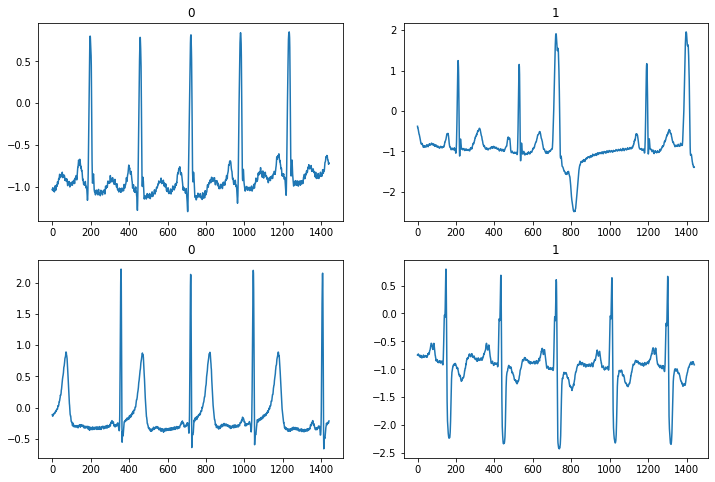

In [40]:
# check out random examples - to make sense of what this data is like
import matplotlib.pyplot as plt 

rand_ind = np.random.choice(len(X_sampled))
X_example = X_sampled[rand_ind]
y_example = y_sampled[rand_ind]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(X_example)
axs[0, 0].set_title('%d' % y_example)

rand_ind = np.random.choice(len(X_sampled))
X_example = X_sampled[rand_ind]
y_example = y_sampled[rand_ind]

axs[1, 0].plot(X_example)
axs[1, 0].set_title('%d' % y_example)

rand_ind = np.random.choice(len(X_sampled))
X_example = X_sampled[rand_ind]
y_example = y_sampled[rand_ind]

axs[0, 1].plot(X_example)
axs[0, 1].set_title('%d' % y_example)

rand_ind = np.random.choice(len(X_sampled))
X_example = X_sampled[rand_ind]
y_example = y_sampled[rand_ind]

axs[1, 1].plot(X_example)
axs[1, 1].set_title('%d' % y_example)




In [57]:
# split into train / val / eval

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train_exp = np.expand_dims(X_train, 2)
X_test_exp = np.expand_dims(X_test, 2)


((51553, 1441), (51553, 1), (17185, 1441), (17185, 1))

In [79]:
# DENSE MODEL 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

#create model
dense_model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1])),
        layers.Dense(100, activation="relu"),
        layers.Dense(200, activation="relu"),
        layers.Dense(
            1, activation="sigmoid", 
        ),
    ]
)

dense_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 100)               144200    
_________________________________________________________________
dense_37 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 201       
Total params: 164,601
Trainable params: 164,601
Non-trainable params: 0
_________________________________________________________________


In [81]:
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, f1_score

dense_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(),
    ]
)

model_out_path = '/blnas/scratch/nripesh/winter_ai_2021_materials/mit_bih_model_dense'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_out_path,
    save_weights_only=False,
    monitor='val_binary_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True,
    restore_best_weights=True,
)

dense_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=8,
    callbacks=[model_checkpoint_callback],
)

dense_model = tf.keras.models.load_model(model_out_path)

y_pred = np.round(dense_model.predict(X_test))
confusion_matrix(y_pred, y_test), f1_score(y_test, y_pred)



(array([[8449,  310],
        [ 144, 8282]]),
 0.9733223645551768)

In [88]:
# CNN MODEL 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


#create model
cnn_model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1], 1)),
        layers.Conv1D(16, kernel_size=3, activation="relu"),
        layers.MaxPool1D(2),
        layers.Conv1D(32, kernel_size=3, activation="relu"),
        layers.MaxPool1D(2),
        layers.Flatten(),
        layers.Dense(
            1, activation="sigmoid", 
        ),
    ]
)

cnn_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 1439, 16)          64        
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 719, 16)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 717, 32)           1568      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 358, 32)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 11456)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 11457     
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________

In [190]:
from tensorflow import keras
from tensorflow.keras import layers

#create model
cnn_model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1], 1)),
        layers.Conv1D(16, kernel_size=3, activation="relu"),
        layers.MaxPool1D(2),
        layers.Conv1D(32, kernel_size=3, activation="relu"),
        layers.MaxPool1D(2),
        layers.Flatten(),
        layers.Dense(
            1, activation="sigmoid", 
        ),
    ]
)

cnn_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(),
    ]
)

cnn_model.fit(
    X_train_exp, y_train,
    validation_data=(X_test_exp, y_test),
    epochs=8,
    callbacks=[model_checkpoint_callback],
)

1568

In [89]:
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

cnn_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(),
    ]
)

model_out_path = '/blnas/scratch/nripesh/winter_ai_2021_materials/mit_bih_model_cnn'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_out_path,
    save_weights_only=False,
    monitor='val_binary_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True,
    restore_best_weights=True,
)

cnn_model.fit(
    X_train_exp, y_train,
    validation_data=(X_test_exp, y_test),
    epochs=8,
    callbacks=[model_checkpoint_callback],
)

cnn_model = tf.keras.models.load_model(model_out_path)

y_pred = np.round(cnn_model.predict(X_test_exp))
confusion_matrix(y_pred, y_test), f1_score(y_test, y_pred)


Epoch 1/8
1612/1612 [==============================] - 16s 10ms/step - loss: 0.3364 - binary_accuracy: 0.8600 - val_loss: 0.2319 - val_binary_accuracy: 0.9112
INFO:tensorflow:Assets written to: /blnas/scratch/nripesh/winter_ai_2021_materials/mit_bih_model_cnn/assets
Epoch 2/8
1612/1612 [==============================] - 15s 10ms/step - loss: 0.1620 - binary_accuracy: 0.9424 - val_loss: 0.1360 - val_binary_accuracy: 0.9559
INFO:tensorflow:Assets written to: /blnas/scratch/nripesh/winter_ai_2021_materials/mit_bih_model_cnn/assets
Epoch 3/8
1612/1612 [==============================] - 15s 9ms/step - loss: 0.1277 - binary_accuracy: 0.9561 - val_loss: 0.1333 - val_binary_accuracy: 0.9568
INFO:tensorflow:Assets written to: /blnas/scratch/nripesh/winter_ai_2021_materials/mit_bih_model_cnn/assets
Epoch 4/8
1612/1612 [==============================] - 15s 9ms/step - loss: 0.1149 - binary_accuracy: 0.9612 - val_loss: 0.1195 - val_binary_accuracy: 0.9618
INFO:tensorflow:Assets written to: /blnas/

(array([[8406,  383],
        [ 187, 8209]]),
 0.9664469036967271)

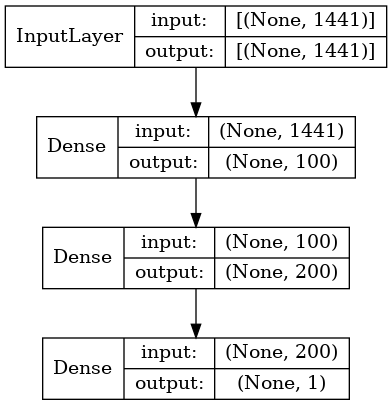

In [84]:
# dense net architecture 
tf.keras.utils.plot_model(
    dense_model,
    to_file="/blnas/scratch/nripesh/winter_ai_2021_materials/dense_model_arch.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


In [ ]:
# CNN archutecture

tf.keras.utils.plot_model(
    cnn_model,
    to_file="/blnas/scratch/nripesh/winter_ai_2021_materials/cnn_model_arch.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


In [133]:
first_layer_weights = cnn_model.weights[0]
for i in range(first_layer_weights.shape[-1]):
    kernel = np.squeeze(first_layer_weights[:, :, i])
    print(kernel)
    
    
second_layer_weights = cnn_model.weights[2]
for i in range(second_layer_weights.shape[-1]):
    kernel = np.squeeze(second_layer_weights[:, :, i])


[-0.47661644 -0.24143496 -0.8699277 ]
[0.0888674  0.08427853 0.331454  ]
[ 0.07213689 -0.43695876 -0.29098606]
[0.52082396 0.6114103  0.30045167]
[-0.22272207 -0.23014104 -0.33339328]
[-0.82269996 -0.1785284  -0.48001817]
[ 0.42905998 -0.33333716  0.1115963 ]
[-0.26080856 -0.3052525  -0.280013  ]
[-0.15581153 -0.29700142 -0.533515  ]
[ 0.6167873  -0.09492619 -0.5032531 ]
[ 0.35762212  0.30928856 -0.03496223]
[ 0.36637524  0.27867043 -0.63144684]
[-0.43934122 -0.04746932 -0.5966336 ]
[-0.57373327 -0.4193058   0.23268314]
[-0.47768918 -0.19031046  0.20396474]
[0.3594709  0.08040199 0.24441437]


In [135]:
# activations 

layer_outputs = [
    cnn_model.layers[0].output, # conv 1
    cnn_model.layers[2].output, # conv 2
    cnn_model.layers[5].output, # dense
] 

# Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(
    inputs=cnn_model.input, outputs=layer_outputs
) 

In [141]:

x_sample, y_sample = X_test_exp[0], y_test[0]
x_sample = np.expand_dims(x_sample, 0)

# Returns a list of five Numpy arrays: one array per layer activation
conv_1_activations, conv_2_activations, dense_activation = activation_model.predict(x_sample) 

conv_1_activations = np.squeeze(conv_1_activations)
conv_2_activations = np.squeeze(conv_2_activations)
dense_activation = np.squeeze(dense_activation)


Text(0.5, 1.0, '[-0.57373327 -0.4193058   0.23268314]')

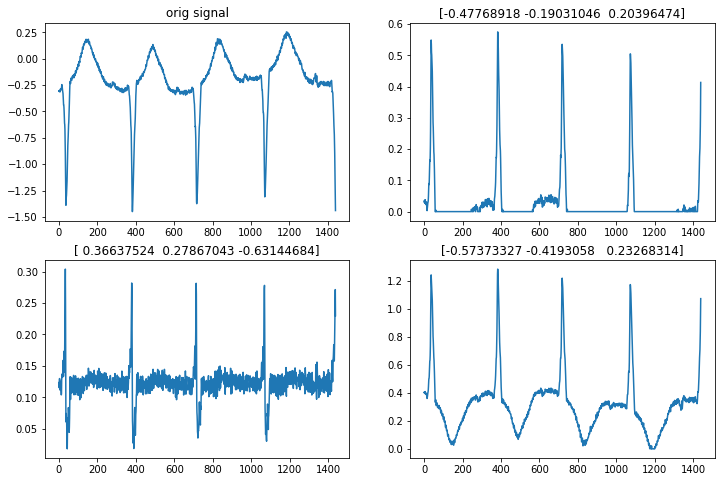

In [163]:
# activations in layer 1
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(x_sample[0])
axes[0, 0].set_title('orig signal')

kernel_id = np.random.choice(16)
kernel = np.squeeze(cnn_model.weights[0][..., kernel_id])
axes[0, 1].plot(conv_1_activations[:, kernel_id])
axes[0, 1].set_title(str(kernel))

kernel_id = np.random.choice(16)
kernel = np.squeeze(cnn_model.weights[0][..., kernel_id])
axes[1, 0].plot(conv_1_activations[:, kernel_id])
axes[1, 0].set_title(str(kernel))

kernel_id = np.random.choice(16)
kernel = np.squeeze(cnn_model.weights[0][..., kernel_id])
axes[1, 1].plot(conv_1_activations[:, kernel_id])
axes[1, 1].set_title(str(kernel))

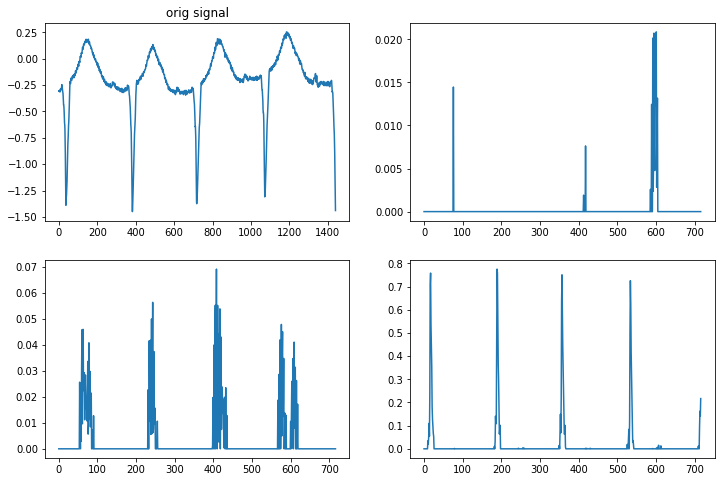

In [177]:
# activations in layer 1
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(x_sample[0])
axes[0, 0].set_title('orig signal')

kernel_id = np.random.choice(32)
kernel = np.squeeze(cnn_model.weights[2][..., kernel_id])
axes[0, 1].plot(conv_2_activations[:, kernel_id])
# axes[0, 1].set_title(str(kernel))

kernel_id = np.random.choice(32)
kernel = np.squeeze(cnn_model.weights[2][..., kernel_id])
axes[1, 0].plot(conv_2_activations[:, kernel_id])
# axes[1, 0].set_title(str(kernel))

kernel_id = np.random.choice(32)
kernel = np.squeeze(cnn_model.weights[2][..., kernel_id])
axes[1, 1].plot(conv_2_activations[:, kernel_id])
# axes[1, 1].set_title(str(kernel))

Text(0.5, 1.0, 'combined edges')

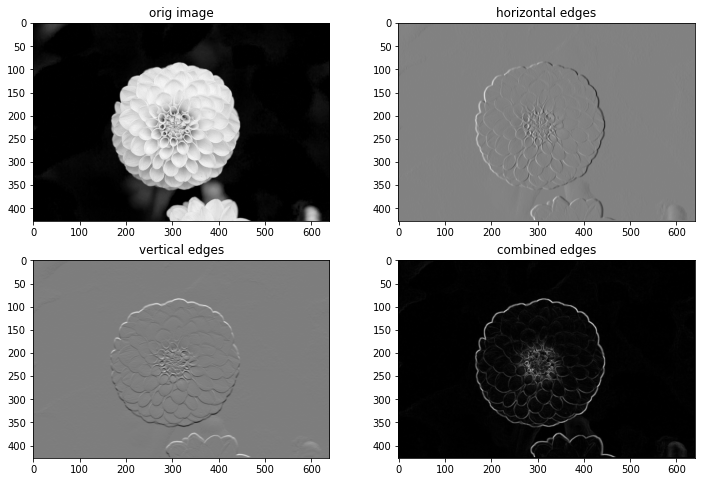

In [187]:
# implementing the conv2d function

from sklearn.datasets import load_sample_image

flower = load_sample_image('flower.jpg')[:, :, 0]
kernel_horiz = np.zeros((3, 3))
kernel_horiz[:, 0] = -1
kernel_horiz[:, -1] = 1

kernel_vertical = np.zeros((3, 3))
kernel_vertical[0, :] = -1
kernel_vertical[-1, :] = 1

def conv_im_kernel(im, kernel):
    # hard-coded for 3 X 3 kernels
    k_h, k_w = kernel.shape
    im_h, im_w = im.shape
    new_im = np.zeros(im.shape)
    for i in range(1, im_h - 2):
        for j in range(1, im_w - 2):
            im_ij = im[i : i + 3, j : j + 3]
            new_im[i, j] = np.sum(np.multiply(im_ij, kernel))
    return new_im

flower_horiz_edge = conv_im_kernel(flower, kernel_horiz)
flower_vertical_edge = conv_im_kernel(flower, kernel_vertical)
flower_edge_all = np.abs(flower_horiz_edge) + np.abs(flower_vertical_edge)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].imshow(flower, cmap='gray')
axes[0, 0].set_title('orig image')
axes[0, 1].imshow(flower_horiz_edge, cmap='gray')
axes[0, 1].set_title('horizontal edges')
axes[1, 0].imshow(flower_vertical_edge, cmap='gray')
axes[1, 0].set_title('vertical edges')
axes[1, 1].imshow(flower_edge_all, cmap='gray')
axes[1, 1].set_title('combined edges')


In [1]:
import tensorflow as tf


tf.__version__

'2.4.0'